# Markov Random Geometric Graph (MRGG):
# A Growth Model for Temporal Dynamic Networks


## Quentin Duchemin \& Yohann De Castro


In [1]:
from MRGG.Graph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Basic applications of the algorithm on simulated data

In [6]:
n = 1000
G = Graph(n,3, sampling_type='markov',enveloppe='heaviside',latitude='mixture', sparsity = 1)
G.SCCHEi_with_R_search()

### Visualization of the envelope and latitude functions

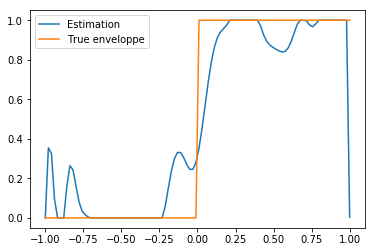

In [7]:
G.plot_estimation_enveloppe()

In [11]:
spec = np.load('../SPEC.npy')
G.spectrumenv = spec
updiag = np.load('../UPDIAG.npy')
G.updiag_gram = updiag

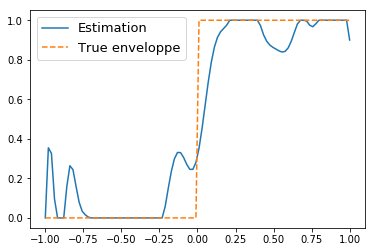

In [25]:
x = np.linspace(-1,1,100)
G.esti[-1]+=0.1
G.esti = list(map(lambda x:max(0,x),G.esti))
G.esti = list(map(lambda x:min(1,x),G.esti))
plt.plot(x, G.esti, label='Estimation')
if True:
    G.true = [G.compute_enveloppe(xi) for xi in x]
    plt.plot(x, G.true, label='True enveloppe', linestyle='--')
plt.legend(fontsize=13)
plt.savefig('env-mix-hea.png')
plt.show()


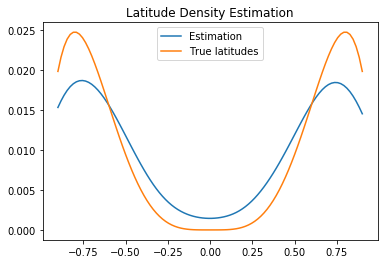

In [17]:
G.plot_densities_latitude()

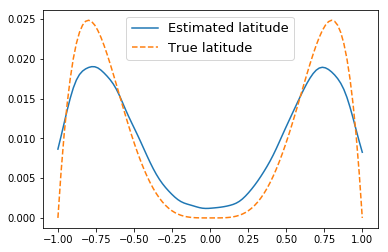

In [26]:
x = np.linspace(-1,1,100)
true = np.array(list(map(G.density_latitude, x)))
from sklearn.neighbors import KernelDensity
X = G.updiag_gram.reshape(-1,1) #+ np.random.normal(0,2*1e-1,(4000-1,1))
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X)
x = np.linspace(-1,1,100)
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens)/sum(np.exp(log_dens)),label='Estimated latitude')
plt.plot(x, true/sum(true), label='True latitude',linestyle='dashed')
plt.legend(fontsize=13)
plt.savefig('lat-mix-hea.png')


### Clustering of the eigenvalues of the adjacency matrix

We plot the eigenvalues of the adjacency matrix of the graph with colors corresponding to clusters built by our algorithm SCCHEi.

In [ ]:
G.plot_eigenvalues_clusters_labeled(5)

In the following figure, we plot the eigenvalues $(p^*_k)_{k \geq 0}$ of the true envelope function $p$ and $(\hat{p}_k)_{k \geq 0}$ of the estimated envelope function (without multiplicity).

In [ ]:
G.plot_comparison_eig_envelope()

In the following, we plot the eigenvalues of the adjacency matrix sorted in decreasing order of magnitude with blue crosses, while red diamonds present the spectrum $(\hat{p}_k)_{k \geq 0}$ built using the algorithm SCCHEi.

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(8)

# 2) Studying the performance of the algorithm with a size increasing

In [ ]:
def study_error(latitude,enveloppe):
    d = 3
    results  = {'error_enveloppe':[],'error_latitude':[],'size':[]}
    listen = list(map(int,np.logspace(np.log10(20),np.log10(1000),20)))
    for n in listen:
        for _ in range(7):
            G = Graph(n, d, sampling_type = 'markov', latitude = latitude, enveloppe = enveloppe)
            G.SCCHEi_with_R_search()
            results['error_enveloppe'].append(G.error_estimation_enveloppe())
            results['error_latitude'].append(G.error_estimation_latitude())
            results['size'].append(n)
    df = pd.DataFrame(results)
    df = df.apply(np.log10)
    return df

import seaborn as sns
def plot_errors(dataframe):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=dataframe, ax = ax)
    ax.set_xlabel('$\log \;n$', fontsize=16)
    ax.set_ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=16)
    ax.set_title('Estimation Error Envelope function', fontsize=16)
    ax = fig.add_subplot(122)
    sns.lineplot(x="size", y="error_latitude", err_style="bars", data=dataframe, ax = ax)
    ax.set_xlabel('$\log \; n$', fontsize=16)
    ax.set_ylabel('$\log \; \delta_2(f^*,\hat{f})$', fontsize=16)
    ax.set_title('Estimation Error Latitude function', fontsize=16)
    plt.savefig('')
    plt.show()

In [ ]:
df = study_error('mixture', 'heaviside')
plot_errors(df)